In [1]:
import seaborn as sns
from fastai.imports import *
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from fastai.structured import *
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
%matplotlib inline


In [2]:
# Add library's path to notebook
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
def evaluate(model, test_features, test_labels):
    
    accuracy = m.score(test_features, test_labels)
    mse = mean_squared_error(test_labels, model.predict(test_features))
    
    print('Model Performance')
    print('Accuracy = {:0.4f}%.'.format(accuracy))
    print('Mean Squared Error = {:0.4f}%.'.format(mse))
    return accuracy

In [66]:
PATH = '/media/joanes/0BB3-1FA1/CSV_DATA/'
files = glob(f'{PATH}*.csv')
# Get only those values that are available before the analysis
filter_cols = ['Total_UnfilledZones', 'Total_FillingQuality', 'TOTAL_QUALITY',  'Total_PorosityQuantity', 'Total_PorosityQuality', 'Time']
df_list = list()
target = list()
for file in files[:100]:
    df = pd.read_csv(file)
    target.append(df.TOTAL_QUALITY.unique()[0])
    df_filtered = df.drop(axis=1, columns=filter_cols)
    filter_col = [col for col in df_filtered if not col.endswith(('VoidContent','VoidQuality', 'Filling', 'FillingQuality'))]
    df_filtered = df_filtered[filter_col]
    df_list.append(df_filtered)

target = pd.DataFrame(target, columns=['valid'])

In [5]:
from ts_featurizer import TimeSeriesFeaturizer
train_ratio = .75
train_size = int(len(df_list) * train_ratio)

tseries = TimeSeriesFeaturizer()
featurized = tseries.featurize(df_list, n_jobs=8)

train, test = featurized[:train_size], featurized[train_size:]

-------------------------------------------------- Training started --------------------------------------------------


100%|██████████| 29.0/29.0 [32:00<00:00, 11.5s/it] 


In [69]:
def split_vals(df, n): return df[:n], df[n:]

object_cols = featurized.loc[:, featurized.dtypes == object].columns
featurized = featurized.drop(axis=1, columns=object_cols)
train, test =  split_vals(featurized, train_size)

In [107]:
target[:train_size].valid.value_counts()

1    52
0    23
Name: valid, dtype: int64

## Store featurized dataframe to feather files

In [70]:
import os 
os.makedirs('tmp', exist_ok=True)
test.reset_index(drop=True).to_feather('tmp/test')
train.reset_index(drop=True).to_feather('tmp/train')
target.reset_index(drop=True).to_feather('tmp/target')

## Read feather file into dataframe

In [71]:
import feather

test = feather.read_dataframe('tmp/test')
train = feather.read_dataframe('tmp/train')
target = feather.read_dataframe('tmp/target')

In [72]:
train.shape, test.shape, target.shape

((75, 7289), (25, 7289), (100, 1))

In [84]:
na_cols = featurized.columns[featurized.isna().any()].tolist()
featurized.fillna(999, inplace=True)

In [87]:
train, test = split_vals(df=featurized, n=train_size)

## Get initial classifier's score

In [105]:
m = RandomForestClassifier(n_estimators=80,max_features=0.5, min_samples_leaf=10, oob_score=True, n_jobs=-1)
m.fit(train, target[:train_size].values.ravel())
print(f'Training score: {m.score(train, target[:train_size].values.ravel())}')
print(f'Testing score: {m.score(test, target[train_size:].values.ravel())}')
print(f'Out of bag score: {m.oob_score_}')
print('\n')
evaluate(m, test, target[train_size:]);

Training score: 0.9466666666666667
Testing score: 0.76
Out of bag score: 0.6533333333333333


Model Performance
Accuracy = 0.7600%.
Mean Squared Error = 0.2400%.


## Get classifier's confusion matrix

Confusion matrix, without normalization


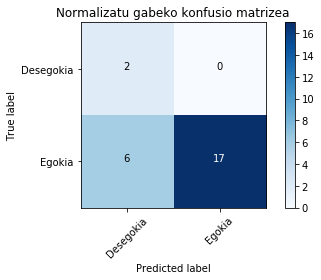

In [106]:
y_test = m.predict(test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, target[train_size:])

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=[ 'Desegokia', 'Egokia'], title='Normalizatu gabeko konfusio matrizea')

plt.show()

## Feature importance

In [90]:
df_raw = pd.concat([train, test])
df_raw.shape

(100, 7289)

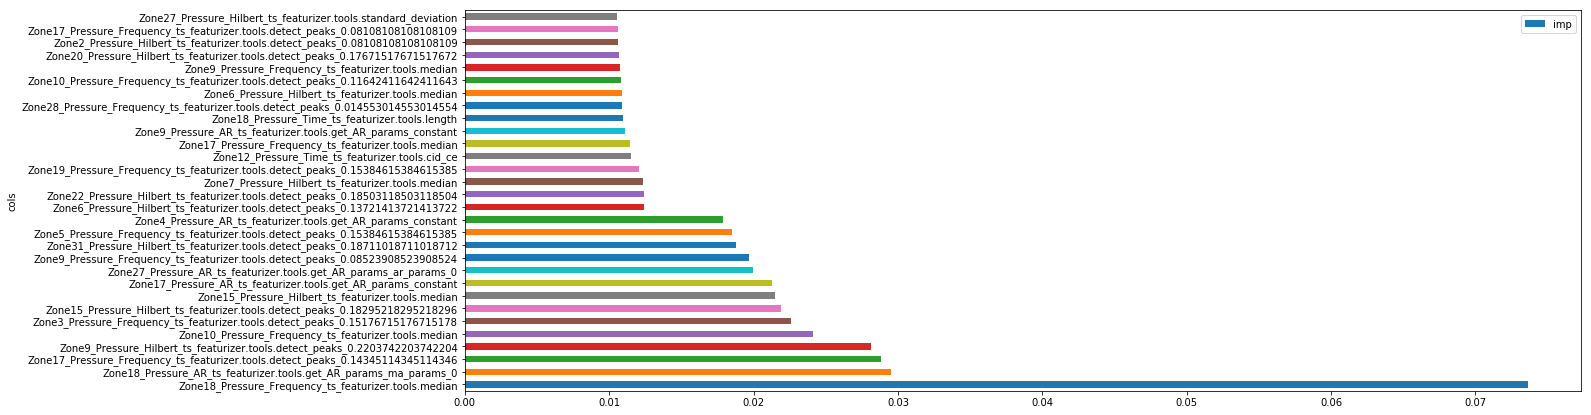

In [91]:
fi = rf_feat_importance(df=train, m=m)

fi[:30].plot('cols', 'imp', 'barh', figsize=(20,7))
plt.show()

df_important = df_raw[fi[:30].cols]

## Check redundancy between features

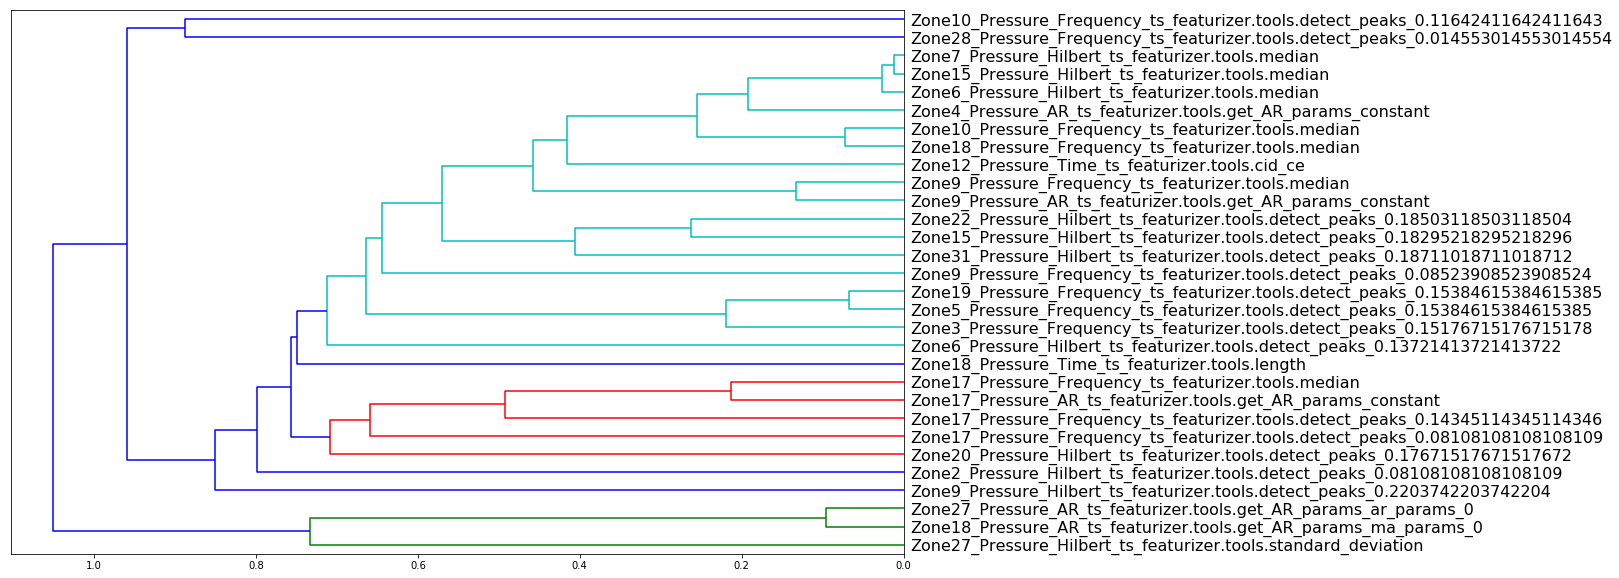

In [92]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_important).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_important.columns, orientation='left', leaf_font_size=16)
plt.show()

### Here we can see that many important features are very highly correlated, so we will try to run the classifier without those who are redundant (only deleting one of both redundant cols)

In [95]:
redundants = ['Zone12_Pressure_Time_numpy.median', 'Zone16_Pressure_Time_scipy.stats.kurtosis', 'Zone24_Pressure_Time_scipy.stats.kurtosis',
            'Zone24_tfilling_Time_numpy.median','Zone24_tfilling_Time_numpy.min', 'Zone24_tfilling_Time_numpy.mean',
             'Zone24_tfilling_Time_numpy.max', 'Zone24_tfilling_Time_numpy.percentile_95']


for red in redundants:
    m = RandomForestClassifier(n_estimators=80,max_features=0.5, min_samples_leaf=10, oob_score=True, n_jobs=-1)
    wo_red = df_important.drop(axis=1, columns=[red])
    m.fit(wo_red[:train_size], target[:train_size].values.ravel())
    print(f'{red}:\n')
    print(f'\tTraining score: {m.score(wo_red[:train_size], target[:train_size].values.ravel())}')
    print(f'\tTesting score: {m.score(wo_red[train_size:], target[train_size:].values.ravel())}')
    print(f'\tOut of bag score: {m.oob_score_}\n')

m = RandomForestClassifier(n_estimators=80,max_features=0.5, min_samples_leaf=10, oob_score=True, n_jobs=-1)
df_wo_redundant = df_important.drop(axis=1, columns=redundants)
m.fit(df_wo_redundant[:train_size], target[:train_size].values.ravel())

print(f'Without redundants:\n')
print(f'\tTraining score: {m.score(df_wo_redundant[:train_size], target[:train_size].values.ravel())}')
print(f'\tTesting score: {m.score(df_wo_redundant[train_size:], target[train_size:].values.ravel())}')
print(f'\tOut of bag score: {m.oob_score_}\n')

base_accuracy = evaluate(m, df_wo_redundant[train_size:], target[train_size:].values.ravel())

KeyError: "['Zone12_Pressure_Time_numpy.median'] not found in axis"

### We can see that without those redundant features, our model is still quite solid, so we remove them

## GridSearch in order to calculate best hiperparameters

In [93]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    figure, ax = plt.subplots(1,1, figsize=(15,6))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=18, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=10)
    ax.grid(True)


In [94]:
n_estimators = [80, 100, 160, 200]
max_features = [0.5, 'log2', 'sqrt', 'auto']
grid_search = GridSearchCV(m,
            dict(n_estimators=n_estimators,
                 max_features=max_features),
                 cv=5, n_jobs=8)

grid_search.fit(df_wo_redundant[:train_size], target[:train_size].values.ravel());
grid_search.best_params_

NameError: name 'df_wo_redundant' is not defined

In [ ]:
plot_grid_search(grid_search.cv_results_, n_estimators, max_features, 'N Estimators', 'Max Features')

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, df_wo_redundant[train_size:], target[train_size:])

### So, we see how the score of the max_features=0.5 is the best, and is quite constant when it comes to n_estimators. Now, we choose max_features=0.5, and we try to 

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [0.5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}
clf = RandomForestClassifier()

pipe_grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=4, n_jobs=-1, verbose=2)

pipe_grid.fit(df_wo_redundant[:train_size], target[:train_size].values.ravel());

In [ ]:
best_grid = pipe_grid.best_estimator_
grid_accuracy = evaluate(best_grid, df_wo_redundant[train_size:], target[train_size:])

## We check the how the feature importance is now and the redundat features

In [ ]:
fi = rf_feat_importance(df=df_wo_redundant[:train_size], m=best_grid)

fi.plot('cols', 'imp', 'barh', figsize=(20,7))
plt.show()


In [ ]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_wo_redundant).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_wo_redundant.columns, orientation='left', leaf_font_size=16)
plt.show()